In [16]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

from tqdm.auto import tqdm

seed = 1234
torch.manual_seed(seed)

# Variables

In [17]:
PATH = './'  # Root
PATH_MODELS = PATH + 'models/'  # ML Models
PATH_MESHES = PATH + 'meshes/'  # 3D objects
PATH_DATASETS = PATH + 'datasets/'  # Datasets
PATH_CHECKPOINTS_GEN = PATH + 'checkpoints/gen/'  # Checkpoints for Generator
PATH_CHECKPOINTS_DIS = PATH + 'checkpoints/dis/'  # Checkpoints for Discriminattor


learning_rate = 0.00001
epochs = 50

mean_gen_loss = 0
mean_dis_loss = 0

LAMBDA = 100

display_step = 5
batch_size = 50

criterion = nn.BCEWithLogitsLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the models

In [18]:
models = np.load(PATH_DATASETS+'dataset.npy', allow_pickle=True).item()
models_tr_x = [torch.from_numpy(np.array([model])*2-1).float() for model in models['train']['x']]
models_tr_y = [torch.from_numpy(np.array([model])*2-1).float() for model in models['train']['y']]
models_ts_x = [torch.from_numpy(np.array([model])*2-1).float() for model in models['test']['x']]
models_ts_y = [torch.from_numpy(np.array([model])*2-1).float() for model in models['test']['y']]

dl_tr = DataLoader(list(zip(models_tr_x, models_tr_y)), batch_size=batch_size, shuffle=True)
dl_ts = DataLoader(list(zip(models_ts_x, models_ts_y)), batch_size=batch_size, shuffle=True)

# GAN

DownSamples y UpSamples

In [19]:
def downsample(channels_in, channels_out, batch=True, kernel_size=4, stride=1):
    layers = []
    layers.append(
        nn.Conv3d(
            channels_in,
            channels_out,
            kernel_size=kernel_size,
            stride=stride,
            bias=not batch
        )
    )
    if batch:
        layers.append(nn.BatchNorm3d(channels_out))
    layers.append(nn.LeakyReLU(negative_slope=0.02))

    return nn.Sequential(*layers)

In [20]:
def upsample(channels_in, channels_out, dropout=False, kernel_size=4, stride=1):
    layers = []
    layers.append(
        nn.ConvTranspose3d(
            channels_in,
            channels_out,
            kernel_size=kernel_size,
            stride=stride,
            bias=False
        )
    )
    layers.append(nn.BatchNorm3d(channels_out))
    
    if dropout:
        layers.append(nn.Dropout3d(0.5))
    layers.append(nn.ReLU())
    return nn.Sequential(*layers)

# Generador y Discriminador

In [54]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.d1 = downsample( 1, 10, batch=False)
        self.d2 = downsample(10, 20)
        self.d3 = downsample(20, 40, stride=2)
        self.d4 = downsample(40, 40, stride=2)
        self.d5 = downsample(40, 40, stride=2, batch=False)
        
        self.u1 = upsample(40, 40, dropout=False, kernel_size=5)
        self.u2 = upsample(80, 40, dropout=False, stride=2)
        self.u3 = upsample(80, 20, stride=2)
        self.u4 = upsample(40, 10)
        
        self.result = nn.ConvTranspose3d(20, 1, kernel_size=4)
        self.act = nn.Tanh()
    
    def forward(self, x):
        s = []
        
        for elem in (self.d1, self.d2, self.d3, self.d4, self.d5):
            x = elem(x)
            if elem is not self.d5:
                s.append(x)
       
        x = self.u1(x)
        x = torch.cat((x, s[-1]), dim=1)
        x = self.u2(x)
        x = torch.cat((x, s[-2]), dim=1)
        x = self.u3(x)
        x = torch.cat((x, s[-3]), dim=1)
        x = self.u4(x)
        x = torch.cat((x, s[-4]), dim=1)
        
        return self.act(self.result(x))

In [71]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.d1 = downsample( 2, 16, batch=False)
        self.d2 = downsample(16, 32)
        self.d3 = downsample(32, 64, stride=2)
        self.d4 = downsample(64, 64, stride=2)
        self.d5 = downsample(64, 64, stride=2)
        
        self.result = nn.ConvTranspose3d(64, 1, kernel_size=4)
        self.act = nn.Sigmoid()
    
    def forward(self, x, y):
        x = torch.cat((x, y), dim=1)

        for elem in (self.d1, self.d2, self.d3, self.d4, self.d5):
            x = elem(x)
        
        return self.act(self.result(x))

# Loss

In [72]:
def discriminator_loss(criterion, real, fake):
    dis_real_loss = criterion(real, torch.ones_like(real))
    dis_fake_loss = criterion(fake, torch.zeros_like(fake))
    
    return (dis_fake_loss + dis_real_loss) / 2

In [73]:
def generator_loss(criterion, real_out, fake_out, target, fake, l):
    dis_fake_loss = criterion(fake_out, torch.ones_like(fake_out))
    target_loss = torch.mean(torch.abs(target - fake))
    
    return dis_fake_loss + l * target_loss

In [74]:
def plot_epoch(data_in, data_fake, data_target):
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    
    ax1.set_title('Input')
    ax2.set_title('Fake')
    
    ax1.voxels(data_in > 0, facecolors='gray')
    ax2.voxels(data_fake > 0, facecolors='red')
    plt.show()

# Create model

In [75]:
gen = Generator().to(device)
dis = Discriminator().to(device)

gen_opt = torch.optim.Adam(gen.parameters(), lr=learning_rate)
dis_opt = torch.optim.Adam(dis.parameters(), lr=learning_rate)

In [76]:
cur_step = 0
for i in range(epochs):
    # Make a checkpoint every 20 epochs
    if i % 5 == 0:
        torch.save(gen.state_dict(), PATH_CHECKPOINTS_GEN + f'gen_{i}.pth')
        torch.save(dis.state_dict(), PATH_CHECKPOINTS_DIS + f'dis_{i}.pth')
    
    for in_data, tg_data in tqdm(dl_tr):
        dis_opt.zero_grad()
        fake = gen(in_data)
        o_fake = dis(in_data, fake)
        o_real = dis(in_data, tg_data)
        dis_loss = discriminator_loss(criterion, o_real, o_fake)
        dis_loss.backward(retain_graph=True)
        dis_opt.step()
        
        gen_opt.zero_grad()
        fake = gen(in_data)
        o_fake = dis(in_data, fake)
        o_real = dis(in_data, tg_data)
        gen_loss = generator_loss(criterion, o_real, o_fake, tg_data, fake, LAMBDA)
        gen_loss.backward()
        gen_opt.step()
        
        mean_dis_loss += dis_loss.item() / display_step
        mean_gen_loss += gen_loss.item() / display_step
        
        if cur_step % display_step == 0 and cur_step > 0:
            print(f'Step {cur_step}: Generator loss: {mean_gen_loss}, Discriminator loss: {mean_dis_loss}')
            # plot_epoch(in_data[0][0], fake[0][0], tg_data[0][0])
            mean_gen_loss = 0
            mean_dis_loss = 0
        cur_step += 1

  5%|▌         | 1/19 [01:12<21:46, 72.59s/it]

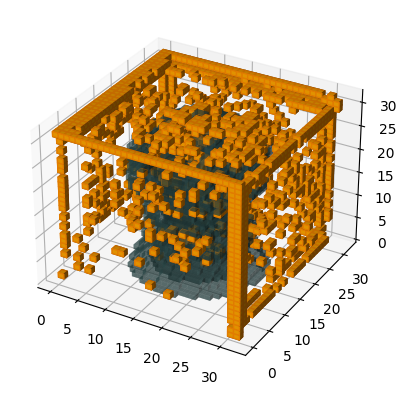

In [197]:
obj = torch.stack([models_tr_x[0], ])
pcs = gen(obj)

obj = obj[0][0].detach().cpu().numpy() > 0
pcs = pcs[0][0].detach().cpu().numpy() > 0

ax = plt.figure().add_subplot(projection='3d')
ax.voxels(obj, facecolors='darkslategray', alpha=0.5)
ax.voxels(pcs & ~obj, facecolors='orange', edgecolors='darkorange')
plt.show()

In [190]:
torch.save(dis.state_dict(), PATH_MODELS + 'dis.pth')
torch.save(gen.state_dict(), PATH_MODELS + 'gen.pth')

# Load saved models

In [192]:
gen = Generator()
dis = Discriminator()


gen.load_state_dict(torch.load(PATH_MODELS+'gen.pth'))
dis.load_state_dict(torch.load(PATH_MODELS+'dis.pth'))

<All keys matched successfully>

# Time to put our model to test

In [208]:
dataset = np.load(PATH_DATASETS+'my_dataset.npy', allow_pickle=True).item()['data']
broken_models = [torch.from_numpy(np.array([model])*2-1).float() for model in dataset]

loaded = DataLoader(dataset, batch_size=batch_size, shuffle=True)

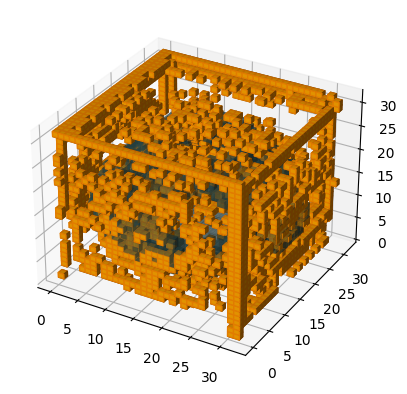

In [210]:
index = np.random.randint(0, len(dataset))

obj = torch.stack([broken_models[index],])
pcs = gen(obj)

obj = obj[0][0].detach().cpu().numpy() > 0
pcs = pcs[0][0].detach().cpu().numpy() > 0

ax = plt.figure().add_subplot(projection='3d')
ax.voxels(obj, facecolors='darkslategray', alpha=0.5)
ax.voxels(pcs, facecolors='orange', edgecolors='darkorange')
plt.show()